In [1]:
import pandas as pd
import numpy as np
!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive
from google.colab import drive

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# data_path = '/home/arsh/Jasleen/Spring 2023/NLP/Group Project/Authorship-Attribution-for-Neural-Text-Generation-master/data/'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = 'drive/MyDrive/Group Project/Authorship-Attribution-for-Neural-Text-Generation-master/data/'

In [5]:
data = pd.read_csv(data_path + 'input.csv')
data.tail()

,text,class
11721,how much of your body is your own how much of ...,instructgpt
11722,how do you keep a space station clean how do y...,instructgpt
11723,the city where you pay a years rent up front t...,instructgpt
11724,the bbc news app gives you the best of bbc new...,instructgpt
11725,learn how the bbc is working to strengthen tru...,instructgpt


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00


In [7]:
# Creating new pairs

import pandas as pd
import numpy as np

# Load the data from the CSV file
# df = pd.read_csv('input.csv')
df=data

# Select only 100 samples from each class
grouped = df.groupby('class').apply(lambda x: x.sample(n=min(len(x), 1000))).reset_index(drop=True)

# Group the selected data by the "class" column
grouped = grouped.groupby('class')

# Randomly select 10 rows from each group
samples = []
for _, group in grouped:
    samples.extend(list(zip(group.sample(n=1000, replace=True).index, 
                             group.sample(n=1000, replace=True).index)))


# Generate pairs from the selected rows and random rows from other classes
pairs = []
labels = []
for i, j in samples:
    # Positive pair
    if df['class'][i] == df['class'][j]:
        pairs.append([df['text'][i], df['text'][j]])
        labels.append(0)

    # Negative pair
    else:
        while True:
            k = np.random.choice(df.index)
            if df['class'][k] != df['class'][i]:
                pairs.append([df['text'][i], df['text'][k]])
                labels.append(1)
                break

# Create a new dataframe with the pairs and labels
new_df = pd.DataFrame({'prompt1': [p[0] for p in pairs], 
                       'prompt2': [p[1] for p in pairs], 
                       'class': labels})

# Save the new dataframe to a CSV file
new_df


,prompt1,prompt2,class
0,news spacexs massive starship prototype lifts ...,news copenhagens new metro is a thing of beaut...,0
1,news threat of violence escalates at greecetur...,news a later bedtime linked with obesity for c...,0
2,news mixing less than 6 hours of sleep with ch...,news bbc news website n tldr a british man has...,0
3,news you cant build the truth on a scaffold of...,news transcripts of the conversations between ...,0
4,news democrats only choice is to impeach trump...,news ride along with the hogwarts express on a...,0
...,...,...,...
10995,trumps speech wont erase his bumbling response...,the donald trump presidency how the world sees...,0
10996,here are the african countries with confirmed ...,5 things to know for march 13 coronavirus iraq...,0
10997,she didnt have paid maternity leave but this m...,an incredibly fast dark matter hurricane is bl...,0
10998,i was the unpopular kid now im a parent heres ...,police in panama found more than 5 tons of dru...,0


In [8]:
counts = new_df['class'].value_counts()
print(counts)

0    7011
1    3989
Name: class, dtype: int64


In [ ]:
# Siamese with lstm

import pandas as pd
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Lambda
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras import backend as K

df_sampled=new_df

# extract the prompts and labels
prompts = df_sampled[['prompt1', 'prompt2']]
labels = df_sampled['class']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(prompts, labels, test_size=0.2, random_state=42)

# create a tokenizer and fit it on the prompts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['prompt1'].append(X_train['prompt2']))

# convert the prompts to sequences
seq1_train = tokenizer.texts_to_sequences(X_train['prompt1'])
seq2_train = tokenizer.texts_to_sequences(X_train['prompt2'])
seq1_test = tokenizer.texts_to_sequences(X_test['prompt1'])
seq2_test = tokenizer.texts_to_sequences(X_test['prompt2'])

# pad the sequences
max_length = max(max(len(x) for x in seq1_train), max(len(x) for x in seq2_train))
seq1_train = pad_sequences(seq1_train, maxlen=max_length, padding='post')
seq2_train = pad_sequences(seq2_train, maxlen=max_length, padding='post')
seq1_test = pad_sequences(seq1_test, maxlen=max_length, padding='post')
seq2_test = pad_sequences(seq2_test, maxlen=max_length, padding='post')

# set the embedding dimension
embedding_dim = 100

# define the shared encoder
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length)
lstm_layer = LSTM(units=50)

# define the Siamese network
input1 = Input(shape=(max_length,))
input2 = Input(shape=(max_length,))
embedded1 = embedding_layer(input1)
embedded2 = embedding_layer(input2)
encoded1 = lstm_layer(embedded1)
encoded2 = lstm_layer(embedded2)
merged = Lambda(lambda x: K.abs(x[0] - x[1]))([encoded1, encoded2])
output = Dense(units=1, activation='sigmoid')(merged)
model = Model(inputs=[input1, input2], outputs=output)

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(x=[seq1_train, seq2_train], y=y_train, batch_size=64, epochs=10, validation_data=([seq1_test, seq2_test], y_test))

# evaluate the model's performance on the test set
accuracy = model.evaluate(x=[seq1_test, seq2_test], y=y_test)[1]
print(f'Test accuracy: {accuracy:.3f}')


<ipython-input-37-5867e0a4db03>:33: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tokenizer.fit_on_texts(X_train['prompt1'].append(X_train['prompt2']))


Epoch 1/10
138/138 [==============================] - 126s 874ms/step - loss: 0.6845 - accuracy: 0.6464 - val_loss: 0.6758 - val_accuracy: 0.6559
Epoch 2/10
138/138 [==============================] - 119s 861ms/step - loss: 0.6711 - accuracy: 0.6465 - val_loss: 0.6636 - val_accuracy: 0.6568
Epoch 3/10
138/138 [==============================] - 117s 846ms/step - loss: 0.6624 - accuracy: 0.6465 - val_loss: 0.6561 - val_accuracy: 0.6559
Epoch 4/10
138/138 [==============================] - 119s 864ms/step - loss: 0.6569 - accuracy: 0.6465 - val_loss: 0.6512 - val_accuracy: 0.6559
Epoch 5/10
138/138 [==============================] - 116s 838ms/step - loss: 0.6536 - accuracy: 0.6465 - val_loss: 0.6481 - val_accuracy: 0.6559
Epoch 6/10
138/138 [==============================] - 115s 832ms/step - loss: 0.6517 - accuracy: 0.6465 - val_loss: 0.6462 - val_accuracy: 0.6559
Epoch 7/10
 74/138 [===============>..............] - ETA: 47s - loss: 0.6484 - accuracy: 0.6512

KeyboardInterrupt: ignored

In [ ]:
new_df

,prompt1,prompt2,class
0,news why britains hated pacer trains just wont...,news most states make it difficult for childre...,0
1,news nathaniel hendren says katlyn alix knew r...,news the tourism legacy of the olympic games i...,0
2,news trump stumbles in first efforts to contro...,news delta announces its biggest flight capaci...,0
3,news megan rapinoe slams us soccer for blatant...,news explore disneys new star wars land in 360...,0
4,news fractured america got together on this is...,news the naked truth is that the united states...,0
...,...,...,...
10995,three british asian trailblazers you need to k...,trumps speech wont erase his bumbling response...,1
10996,were not talking to our girls enough about mon...,all aboard indias joyful toy train style 11 an...,1
10997,business is booming for local woman making mas...,the story behind vietnams crazy house the stor...,1
10998,alabama town mirrors us class divide on immigr...,opinion we need to flatten the curve trump an...,1


In [ ]:
# Siamese with bilstm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data into a pandas dataframe
# data = pd.read_csv('data.csv')
data=new_df


# Split into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenize the prompts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['prompt1'] + train_data['prompt2'])
vocab_size = len(tokenizer.word_index) + 1

# Convert the prompts to sequences of tokens
train_seqs1 = tokenizer.texts_to_sequences(train_data['prompt1'])
train_seqs2 = tokenizer.texts_to_sequences(train_data['prompt2'])
test_seqs1 = tokenizer.texts_to_sequences(test_data['prompt1'])
test_seqs2 = tokenizer.texts_to_sequences(test_data['prompt2'])

# Pad the sequences to the same length
max_length = 200
train_seqs1 = pad_sequences(train_seqs1, maxlen=max_length, padding='post', truncating='post')
train_seqs2 = pad_sequences(train_seqs2, maxlen=max_length, padding='post', truncating='post')
test_seqs1 = pad_sequences(test_seqs1, maxlen=max_length, padding='post', truncating='post')
test_seqs2 = pad_sequences(test_seqs2, maxlen=max_length, padding='post', truncating='post')

# Define the Siamese neural network architecture with BiLSTM
embedding_dim = 128
lstm_dim = 64

input_1 = layers.Input(shape=(max_length,))
input_2 = layers.Input(shape=(max_length,))

embedding_layer = layers.Embedding(vocab_size, embedding_dim)

lstm_layer = layers.Bidirectional(layers.LSTM(lstm_dim))

encoded1 = lstm_layer(embedding_layer(input_1))
encoded2 = lstm_layer(embedding_layer(input_2))

merged = layers.concatenate([encoded1, encoded2], axis=-1)
merged = layers.Dense(32, activation='relu')(merged)
merged = layers.Dropout(0.2)(merged)
output = layers.Dense(1, activation='sigmoid')(merged)

siamese_model = models.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.01)
siamese_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 128

siamese_model.fit([train_seqs1, train_seqs2], train_data['class'],
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=([test_seqs1, test_seqs2], test_data['class']))


Epoch 1/10
69/69 [==============================] - 39s 443ms/step - loss: 0.6141 - accuracy: 0.6574 - val_loss: 0.6122 - val_accuracy: 0.6705
Epoch 2/10
69/69 [==============================] - 18s 257ms/step - loss: 0.5125 - accuracy: 0.7326 - val_loss: 0.5663 - val_accuracy: 0.6818
Epoch 3/10
69/69 [==============================] - 15s 216ms/step - loss: 0.3409 - accuracy: 0.8502 - val_loss: 0.6654 - val_accuracy: 0.6741
Epoch 4/10
69/69 [==============================] - 14s 207ms/step - loss: 0.1830 - accuracy: 0.9277 - val_loss: 0.8831 - val_accuracy: 0.6845
Epoch 5/10
69/69 [==============================] - 10s 142ms/step - loss: 0.1137 - accuracy: 0.9590 - val_loss: 1.0744 - val_accuracy: 0.7055
Epoch 6/10
69/69 [==============================] - 12s 170ms/step - loss: 0.0728 - accuracy: 0.9747 - val_loss: 1.3814 - val_accuracy: 0.6927
Epoch 7/10
69/69 [==============================] - 13s 194ms/step - loss: 0.0421 - accuracy: 0.9837 - val_loss: 1.8479 - val_accuracy: 0.6727

In [9]:
# Siamese with word2vec

import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data into a pandas dataframe
data=new_df

# Split into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenize the prompts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['prompt1'] + train_data['prompt2'])
vocab_size = len(tokenizer.word_index) + 1

# Convert the prompts to sequences of tokens
train_seqs1 = tokenizer.texts_to_sequences(train_data['prompt1'])
train_seqs2 = tokenizer.texts_to_sequences(train_data['prompt2'])
test_seqs1 = tokenizer.texts_to_sequences(test_data['prompt1'])
test_seqs2 = tokenizer.texts_to_sequences(test_data['prompt2'])

# Pad the sequences to the same length
max_length = 200
train_seqs1 = pad_sequences(train_seqs1, maxlen=max_length, padding='post', truncating='post')
train_seqs2 = pad_sequences(train_seqs2, maxlen=max_length, padding='post', truncating='post')
test_seqs1 = pad_sequences(test_seqs1, maxlen=max_length, padding='post', truncating='post')
test_seqs2 = pad_sequences(test_seqs2, maxlen=max_length, padding='post', truncating='post')

# Train Word2Vec model on the corpus
sentences = [sentence.split() for sentence in train_data['prompt1'] + train_data['prompt2']]
word2vec_model = Word2Vec(sentences, vector_size=128, window=5, min_count=1, workers=4)

# Create embedding matrix for the tokenizer vocabulary
embedding_dim = 128
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define the Siamese neural network architecture with BiLSTM
lstm_dim = 64

input_1 = layers.Input(shape=(max_length,))
input_2 = layers.Input(shape=(max_length,))

embedding_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])

lstm_layer = layers.Bidirectional(layers.LSTM(lstm_dim))

encoded1 = lstm_layer(embedding_layer(input_1))
encoded2 = lstm_layer(embedding_layer(input_2))

merged = layers.concatenate([encoded1, encoded2], axis=-1)
merged = layers.Dense(32, activation='relu')(merged)
merged = layers.Dropout(0.2)(merged)
output = layers.Dense(1, activation='sigmoid')(merged)

siamese_model = models.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.01)
siamese_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 128


siamese_model.fit([train_seqs1, train_seqs2], train_data['class'],
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=([test_seqs1, test_seqs2], test_data['class']))


Epoch 1/10
69/69 [==============================] - 34s 293ms/step - loss: 0.5661 - accuracy: 0.7043 - val_loss: 0.4733 - val_accuracy: 0.7800
Epoch 2/10
69/69 [==============================] - 17s 249ms/step - loss: 0.4200 - accuracy: 0.7949 - val_loss: 0.4019 - val_accuracy: 0.8191
Epoch 3/10
69/69 [==============================] - 18s 265ms/step - loss: 0.3578 - accuracy: 0.8215 - val_loss: 0.4179 - val_accuracy: 0.8095
Epoch 4/10
69/69 [==============================] - 15s 219ms/step - loss: 0.2806 - accuracy: 0.8659 - val_loss: 0.4908 - val_accuracy: 0.7764
Epoch 5/10
69/69 [==============================] - 12s 179ms/step - loss: 0.2063 - accuracy: 0.9101 - val_loss: 0.5634 - val_accuracy: 0.7627
Epoch 6/10
69/69 [==============================] - 13s 191ms/step - loss: 0.1409 - accuracy: 0.9434 - val_loss: 0.6977 - val_accuracy: 0.7723
Epoch 7/10
69/69 [==============================] - 10s 142ms/step - loss: 0.1010 - accuracy: 0.9603 - val_loss: 0.8792 - val_accuracy: 0.7723

In [ ]:
# Evaluate the model
loss, accuracy = siamese_model.evaluate([test_seqs1, test_seqs2], test_data['class'])
print('Test loss:', loss)
print('Test accuracy:', accuracy)


69/69 [==============================] - 1s 17ms/step - loss: 1.4349 - accuracy: 0.7618
Test loss: 1.4348772764205933
Test accuracy: 0.7618181705474854


In [10]:
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = siamese_model.predict([test_seqs1, test_seqs2])
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
target_names = ['class 0', 'class 1']
print(classification_report(test_data['class'], y_pred, target_names=target_names))


69/69 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

     class 0       0.83      0.81      0.82      1432
     class 1       0.67      0.70      0.68       768

    accuracy                           0.77      2200
   macro avg       0.75      0.76      0.75      2200
weighted avg       0.78      0.77      0.77      2200



69/69 [==============================] - 2s 32ms/step


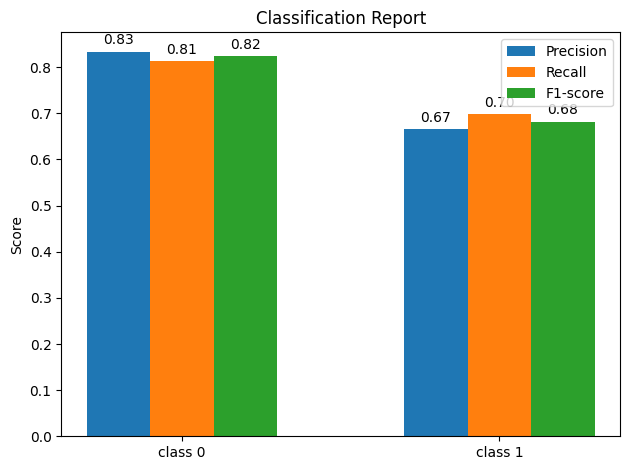

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred = siamese_model.predict([test_seqs1, test_seqs2])
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
target_names = ['class 0', 'class 1']
report = classification_report(test_data['class'], y_pred, target_names=target_names, output_dict=True)

# Extract the metrics
precision = [report[name]['precision'] for name in target_names]
recall = [report[name]['recall'] for name in target_names]
f1_score = [report[name]['f1-score'] for name in target_names]

# Create a bar plot
x = np.arange(len(target_names))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(target_names)
ax.legend()

# Add values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


In [ ]:
def predict_same(prompt1, prompt2):
    # Preprocess input prompts using the same tokenizer used during training
    prompt1_seq = tokenizer.texts_to_sequences([prompt1])[0]
    prompt2_seq = tokenizer.texts_to_sequences([prompt2])[0]
    prompt1_padded = pad_sequences([prompt1_seq], maxlen=max_length, padding='post', truncating='post')
    prompt2_padded = pad_sequences([prompt2_seq], maxlen=max_length, padding='post', truncating='post')
    
    # Predict using the trained model
    prediction = siamese_model.predict([prompt1_padded, prompt2_padded])[0][0]
    
    # Return True if prediction is above a threshold, False otherwise
    threshold = 0.5
    return prediction < threshold


In [ ]:
prompt1 = input("prompt1")
prompt2 = input("prompt2")
same_or_not = predict_same(prompt1, prompt2)
if same_or_not:
  print("Both generated by same method")  # Output: True
else:
  print("Both generated by different method")


prompt1annotated trumps oval office remarks on coronavirus annotated trumps oval office remarks on coronavirus on wednesday president donald trump delivered a solemn address to the nation in the oval office of the white house regarding the outbreak of the novel coronavirus the president was flanked by vice president mike pence and the heads of the nations top health agencies who he had tasked to lead the governments response to the outbreak  in his remarks trump opened by recognizing the gravity of the situation saying that in the days and weeks ahead were going to have to focus on the health and safety of the american people he went on to promise that the federal government would spare no effort in containing the spread of the virus and that his administration would work with state and local governments to ensure adequate medical supplies and screenings  trump also discussed the governments actions to provide support for workers and businesses affected by the outbreak such as expandin